In [17]:
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import shap
import polars as pl
import re
import nltk
from nltk.corpus import stopwords
from accelerate import Accelerator
from datasets import Dataset, load_dataset
from transformers import(
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoConfig,
    default_data_collator,
    get_scheduler,
)
from itertools import chain
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch
import math
import gdown
import statistics

In [2]:
# run accelerate config

Keep running until True

In [3]:
np.random.seed(101)
shap.initjs()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /users/ujan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##### Load sample sports and political data

In [4]:
sports_df = pl.read_csv('~/sports-language-in-politics/data/processed/sports_sample.csv')
politics_df = pl.read_csv('~/sports-language-in-politics/data/processed/politics_sample.csv')

##### Extract sports and political comments and clean. Generate boolean labels

In [5]:
sports_comments = [re.sub(r"[^a-zA-Z0-9]+", ' ', comment).lower() for comment in sports_df['body'].to_list()]
political_comments = [re.sub(r"[^a-zA-Z0-9]+", ' ', comment).lower() for comment in politics_df['body'].to_list()]

Filter short comments

In [6]:
thresh = 50  # 20
sports_comments_long = []
political_comments_long = []

s_lens = [len(s.split()) for s in sports_comments]
p_lens = [len(c.split()) for c in political_comments]

for i in range(len(sports_comments)):
    if s_lens[i] >= thresh:
        sports_comments_long.append(sports_comments[i])
for i in range(len(political_comments)):
    if p_lens[i] >= thresh:
        political_comments_long.append(political_comments[i])

Take with a sample to build vocab

In [7]:
classifier_sample_size = 50000
sports_comments = sports_comments_long[:classifier_sample_size]
political_comments = political_comments_long[:classifier_sample_size]

# labels
sports_y = np.ones(len(sports_comments), dtype=bool)
politics_y = np.zeros(len(political_comments), dtype=bool)

##### Concatenate, shuffle and split into train and test

In [8]:
sports_comments.extend(political_comments)
y = np.concatenate((sports_y, politics_y))

corpus_train, corpus_test, y_train, y_test = train_test_split(
    sports_comments, y, test_size=0.2, random_state=7
)

print('train data size : {}'.format(len(corpus_train)))
print('test data size : {}'.format(len(corpus_test)))

train data size : 80000
test data size : 20000


##### Fit a linear logistic regression model

In [9]:
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(
    corpus_train
).toarray()  # sparse also works but Explanation slicing is not yet supported
X_test = vectorizer.transform(corpus_test).toarray()

model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.91      0.96      0.93      9976
        True       0.95      0.91      0.93     10024

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



##### Explain the linear model

In [10]:
explainer = shap.Explainer(
    model, X_train, feature_names=vectorizer.get_feature_names_out()
)
shap_values = explainer(X_test)

##### Summarize the effect of all the features

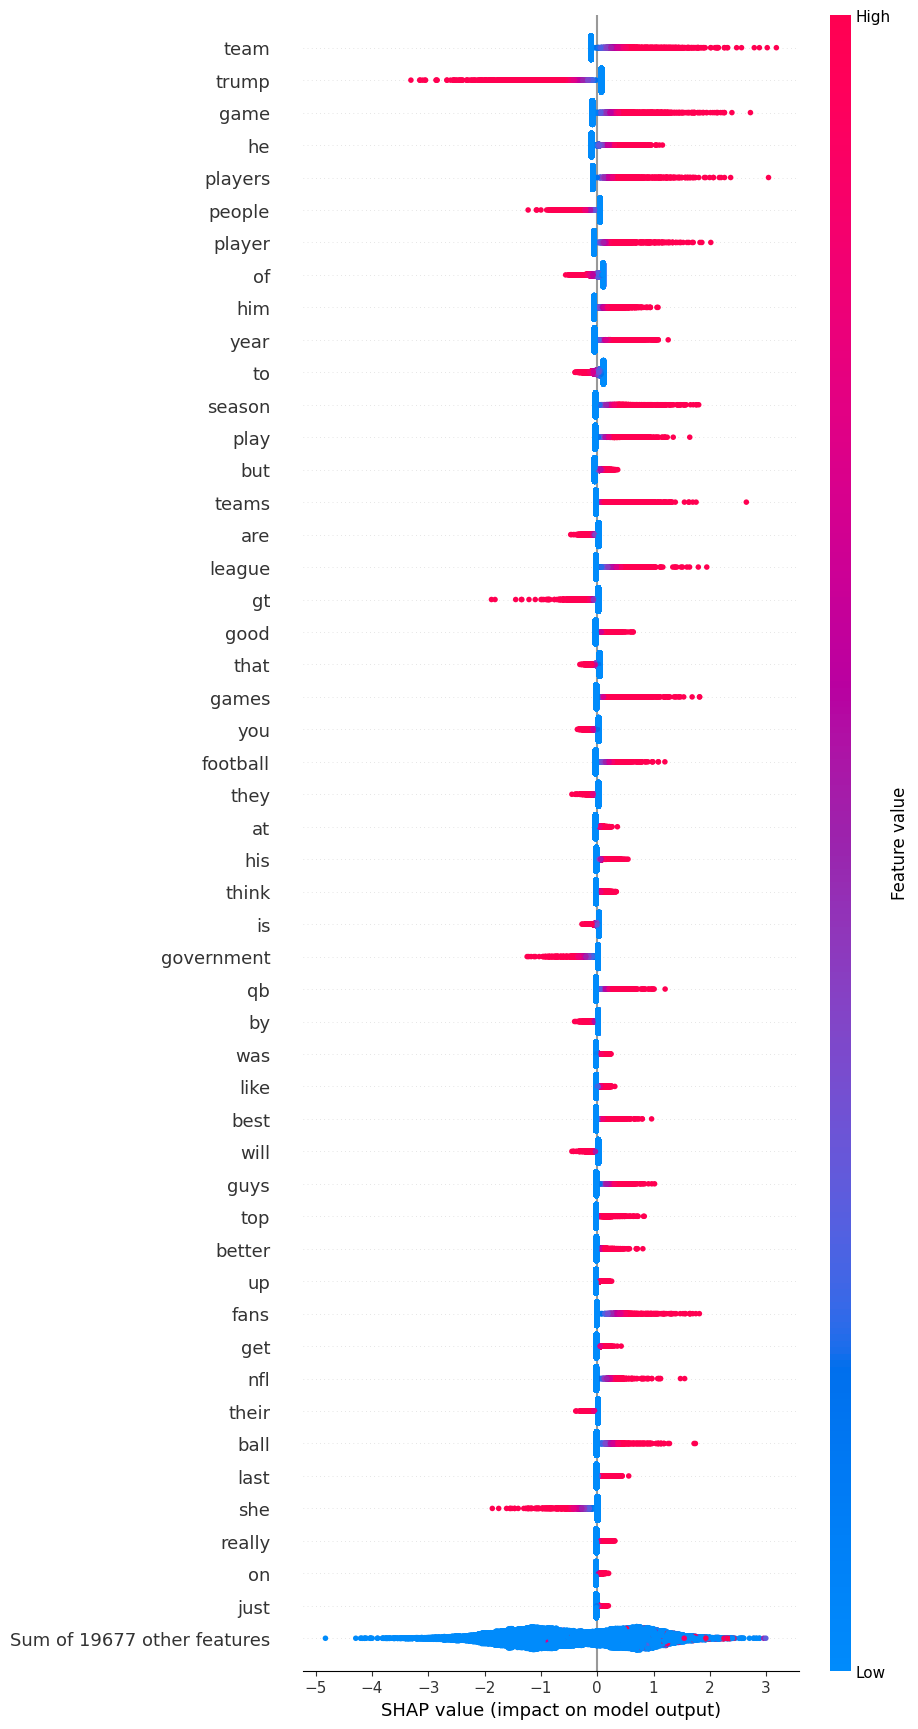

In [11]:
shap.plots.beeswarm(shap_values, max_display=50)

##### Shapley values tell us how each feature affects the prediction of a data point.

We could look at the average contribution of a feature across data points in terms of impact on model output. However we are interested in features that strongly predict sports or political content. Therefore it perhaps makes sense to look at maximum and minimum values

In [12]:
min_values = np.min(shap_values.values, axis=0)
max_values = np.max(shap_values.values, axis=0)

##### Get feature names from the Tfidf vectorizer

In [13]:
feature_names = vectorizer.get_feature_names_out()

##### Fix a threshold to select features

In [14]:
thresh = 0.35

# word : min/max shap value
sports_words = {}
political_words = {}

for f in range(len(feature_names)):
    name = feature_names[f]
    if abs(min_values[f]) + thresh < abs(max_values[f]):
        sports_words[name] = max_values[f]
    elif abs(min_values[f]) > abs(max_values[f]) + thresh:
        political_words[name] = min_values[f]

print('sports words : {}'.format(len(sports_words)))
print('political words : {}'.format(len(political_words)))

sports words : 159
political words : 166


##### Filter sports vocab

In [16]:
sports_vocab = {}

# filter stop words
cachedStopWords = stopwords.words("english")
for word, value in sports_words.items():
    if word not in cachedStopWords:
        sports_vocab[word] = value

print('sports words : {}'.format(len(sports_vocab)))

sports words : 156


##### CLM : Use this as a sports vocab

Arguments

In [12]:
# args

lm_sample_size = classifier_sample_size
gradient_accumulation_steps = 1
model_name_or_path = 'gpt2'
text_column_name = 'text'
preprocessing_num_workers = 4
block_size = 128
per_device_train_batch_size = 4
per_device_eval_batch_size = 4
weight_decay = 0.0
learning_rate = 5e-5
lr_scheduler_type = 'linear'
num_warmup_steps = 0
train_steps = 5000
eval_steps = 500

Get accelerator

In [13]:
accelerator = Accelerator(gradient_accumulation_steps=gradient_accumulation_steps)

Prepare data

Get a larger sample size for language modeling

In [14]:
political_comments = political_comments_long[:lm_sample_size]

data = [{text_column_name:t} for t in political_comments]
pol_dataset = Dataset.from_list(data)

Load model and tokenizer

In [15]:
config = AutoConfig.from_pretrained(model_name_or_path)
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, config=config)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

##### Check perplexity on wikitext

In [18]:
test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (287644 > 1024). Running this sequence through the model will result in indexing errors


In [21]:
max_length = model.config.n_positions
stride = 256
seq_len = encodings.input_ids.size(1)
device = "cuda" if torch.cuda.is_available() else "cpu"

nlls = []
prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
    input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

        # loss is calculated using CrossEntropyLoss which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
        # to the left by 1.
        neg_log_likelihood = outputs.loss

    nlls.append(neg_log_likelihood)

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

ppl = torch.exp(torch.stack(nlls).mean())
print(ppl)

  0%|          | 0/1124 [00:00<?, ?it/s]

KeyboardInterrupt: 

##### Check perplexity on wikitext

In [48]:
encodings = tokenizer("\n\n".join(political_comments), return_tensors="pt")

In [ ]:
max_length = model.config.n_positions
stride = 256
seq_len = encodings.input_ids.size(1)
device = "cuda" if torch.cuda.is_available() else "cpu"

nlls = []
prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
    input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

        # loss is calculated using CrossEntropyLoss which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
        # to the left by 1.
        neg_log_likelihood = outputs.loss

    nlls.append(neg_log_likelihood)

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

ppl = torch.exp(torch.stack(nlls).mean())
print(ppl)

Preprocess dataset

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples[text_column_name])
    
column_names = pol_dataset.column_names
with accelerator.main_process_first():
    tokenized_dataset = pol_dataset.map(
        tokenize_function,
        batched=True,
        num_proc=preprocessing_num_workers,
        remove_columns=column_names,
        desc="Running tokenizer on dataset",
    )

Main data processing function that will concatenate all texts from the dataset and generate chunks of block_size

In [ ]:
def group_texts(examples):
    # concatenate all texts.
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # we drop the small remainder, and if the total_length < block_size  we exclude this batch and return an empty dict.
    # we could add padding if the model supported it instead of this drop, you can customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

with accelerator.main_process_first():
    lm_dataset = tokenized_dataset.map(
        group_texts,
        batched=True,
        num_proc=preprocessing_num_workers,
        desc=f"Grouping texts in chunks of {block_size}",
    )

In [38]:
def preprocess(examples):
    result = tokenizer(examples[text_column_name], truncation=True)
    result["labels"] = result["input_ids"].copy()
    return result

with accelerator.main_process_first():
    lm_dataset = pol_dataset.map(
        preprocess,
        batched=True,
        num_proc=preprocessing_num_workers,
        remove_columns=pol_dataset.column_names
    )

Map (num_proc=4):   0%|          | 0/50000 [00:00<?, ? examples/s]

Split into train test

In [41]:
lm_dataset = lm_dataset.train_test_split(test_size=0.2)
train_dataset = lm_dataset['train']
eval_dataset = lm_dataset['test']

Dataloaders

In [196]:
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=per_device_train_batch_size
)
eval_dataloader = DataLoader(
    eval_dataset, collate_fn=default_data_collator, batch_size=per_device_eval_batch_size
)

Optimizer

In [197]:
# split weights in two groups, one with weight decay and the other not.
no_decay = ["bias", "layer_norm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=learning_rate)

Scheduler

In [198]:
lr_scheduler = get_scheduler(
    name=lr_scheduler_type,
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps * gradient_accumulation_steps,
    num_training_steps=train_steps * gradient_accumulation_steps,
)

Prepare everything with accelerator

In [199]:
model, optimizer, train_dataloader, eval_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader, lr_scheduler
)
total_batch_size = per_device_train_batch_size * accelerator.num_processes * gradient_accumulation_steps

##### Evaluate sports vocab probabilities of GPT2

First let's evaluate probabilities of tokens by feeding the labels. Later we can check probabilities with autoregressive decoding

Get tokenizer vocab and check common tokens with sports vocab

In [144]:
stripped_vocab = {}
for token, id in tokenizer.get_vocab().items():
    stripped_vocab[tokenizer.convert_tokens_to_string([token]).strip()] = id

sports2ids = {}
for key, val in sports_vocab.items():
    if key in stripped_vocab:
        sports2ids[key] = stripped_vocab[key]

ids2sports = {v: k for k, v in sports2ids.items()}

For each sample get probabilities of sports tokens and sum

In [160]:
sports2prob = {key:[] for key, _ in sports2ids.items()}

eval_bar = tqdm(range(len(eval_dataloader)), position=0, disable=not accelerator.is_local_main_process)
for step, batch in enumerate(eval_dataloader):
    with torch.no_grad():
        logits = model(**batch).logits
        probs = torch.nn.functional.softmax(logits, dim=2)
        for id, token in ids2sports.items():
            num = probs[:,:,id].shape[0] * probs[:,:,id].shape[1]
            sports2prob[token].append(torch.sum(probs[:,:,id])/num)
    eval_bar.update(1)

  0%|          | 0/1717 [00:00<?, ?it/s]

In [164]:
sport_probs_before = {}

for key, val in sports2prob.items():
    sport_probs_before[key] = sum(val).detach().cpu()

sport_probs_before

{'back': tensor(0.0587),
 'ball': tensor(0.0257),
 'baseball': tensor(0.0166),
 'basketball': tensor(0.0114),
 'beat': tensor(0.1289),
 'bench': tensor(0.0015),
 'best': tensor(0.0110),
 'better': tensor(0.0046),
 'big': tensor(0.0333),
 'bowl': tensor(0.0018),
 'bucks': tensor(0.0246),
 'cap': tensor(0.0742),
 'career': tensor(0.0887),
 'championship': tensor(0.0046),
 'city': tensor(0.2789),
 'club': tensor(0.0533),
 'clubs': tensor(0.0118),
 'coach': tensor(0.0187),
 'coaches': tensor(0.0057),
 'coaching': tensor(0.0066),
 'contract': tensor(0.0006),
 'cup': tensor(0.0029),
 'curry': tensor(0.0046),
 'defender': tensor(0.0105),
 'defense': tensor(0.0007),
 'defensive': tensor(0.0221),
 'draft': tensor(0.0325),
 'dude': tensor(0.1289),
 'fa': tensor(0.0363),
 'fan': tensor(0.0061),
 'fans': tensor(0.0645),
 'field': tensor(0.0154),
 'finals': tensor(0.0053),
 'football': tensor(0.0012),
 'foul': tensor(0.0147),
 'fuck': tensor(0.5850),
 'game': tensor(0.0090),
 'games': tensor(0.1274

With autoregressive generation

In [ ]:
sports2prob = {key:[] for key, _ in sports2ids.items()}

eval_bar = tqdm(range(len(eval_dataloader)), position=0, disable=not accelerator.is_local_main_process)
for step, batch in enumerate(eval_dataloader):
    with torch.no_grad():
        print(model.generate(batch['input_ids']))
        logits = model(**batch).logits
        probs = torch.nn.functional.softmax(logits, dim=2)
        for id, token in ids2sports.items():
            num = probs[:,:,id].shape[0] * probs[:,:,id].shape[1]
            sports2prob[token].append(torch.sum(probs[:,:,id])/num)
    eval_bar.update(1)

##### Fine tune GPT2 on sample political comments and evalute sports vocab probabilities

Train

In [200]:
completed_steps = 0
total_loss = 0

progress_bar = tqdm(range(train_steps), position=0, disable=not accelerator.is_local_main_process)
eval_bar = tqdm(range(len(eval_dataloader)), position=1, disable=not accelerator.is_local_main_process)

while True:
    model.train()
    for batch in train_dataloader:
        with accelerator.accumulate(model):
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.detach().float()
            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
        if accelerator.sync_gradients:
            progress_bar.update(1)
            completed_steps += 1

        if completed_steps % eval_steps == 0:
            model.eval()
            losses = []
            for step, batch in enumerate(eval_dataloader):
                with torch.no_grad():
                    outputs = model(**batch)
    
                loss = outputs.loss
                losses.append(accelerator.gather_for_metrics(loss.repeat(per_device_eval_batch_size)))

                eval_bar.update(1)

            eval_bar.refresh()
            eval_bar.reset()
    
            losses = torch.cat(losses)
            try:
                eval_loss = torch.mean(losses)
                perplexity = math.exp(eval_loss)
            except OverflowError:
                perplexity = float("inf")
    
            accelerator.print(
                f"step {completed_steps}: perplexity: {perplexity} eval_loss: {eval_loss} train_loss: {total_loss.item()/len(train_dataloader)}")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                './gpt2_'+str(completed_steps), is_main_process=accelerator.is_main_process, save_function=accelerator.save
            )
            train_loss = 0
            model.train()

        if completed_steps >= train_steps:
            raise Exception("Max train steps reached")

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/2801 [00:00<?, ?it/s]

RuntimeError: MPS backend out of memory (MPS allocated: 6.85 GB, other allocations: 2.16 GB, max allowed: 9.07 GB). Tried to allocate 97.39 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).